**Import Libraries and Dataset**

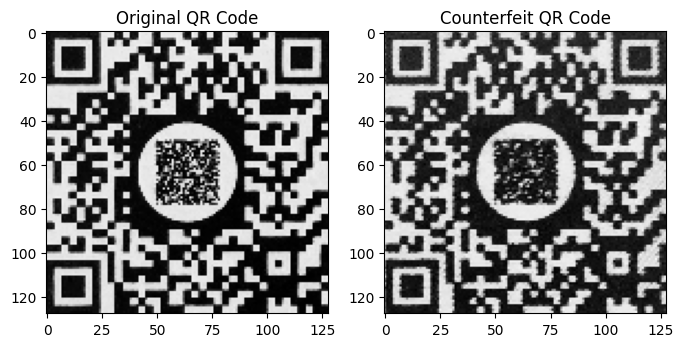

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage.measure import shannon_entropy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return cv2.resize(img, (128, 128))

first_print = load_image("/content/drive/MyDrive/Assignment Data/First Print/input_image_active (1).png")
second_print = load_image("/content/drive/MyDrive/Assignment Data/Second Print/input_image_active (1).png")

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(first_print, cmap='gray')
axs[0].set_title("Original QR Code")
axs[1].imshow(second_print, cmap='gray')
axs[1].set_title("Counterfeit QR Code")
plt.show()


Data Exploration and Feature Extraction

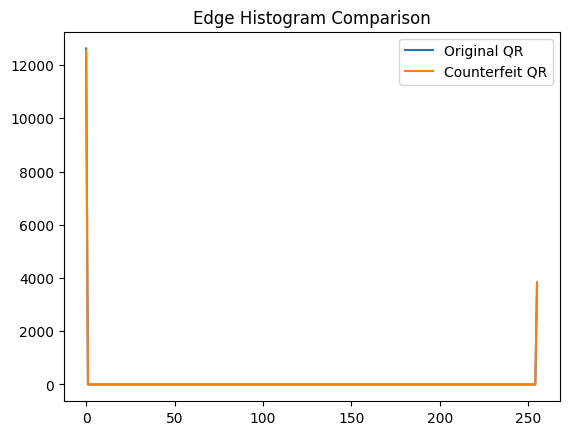

In [2]:
def edge_features(image):
    edges = cv2.Canny(image, 100, 200)
    hist = np.histogram(edges, bins=256)[0]
    return hist
first_edges = edge_features(first_print)
second_edges = edge_features(second_print)

plt.plot(first_edges, label="Original QR")
plt.plot(second_edges, label="Counterfeit QR")
plt.legend()
plt.title("Edge Histogram Comparison")
plt.show()


In [3]:
def count_qr_contours(image):
    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return len(contours)
original_contours = count_qr_contours(first_print)
counterfeit_contours = count_qr_contours(second_print)


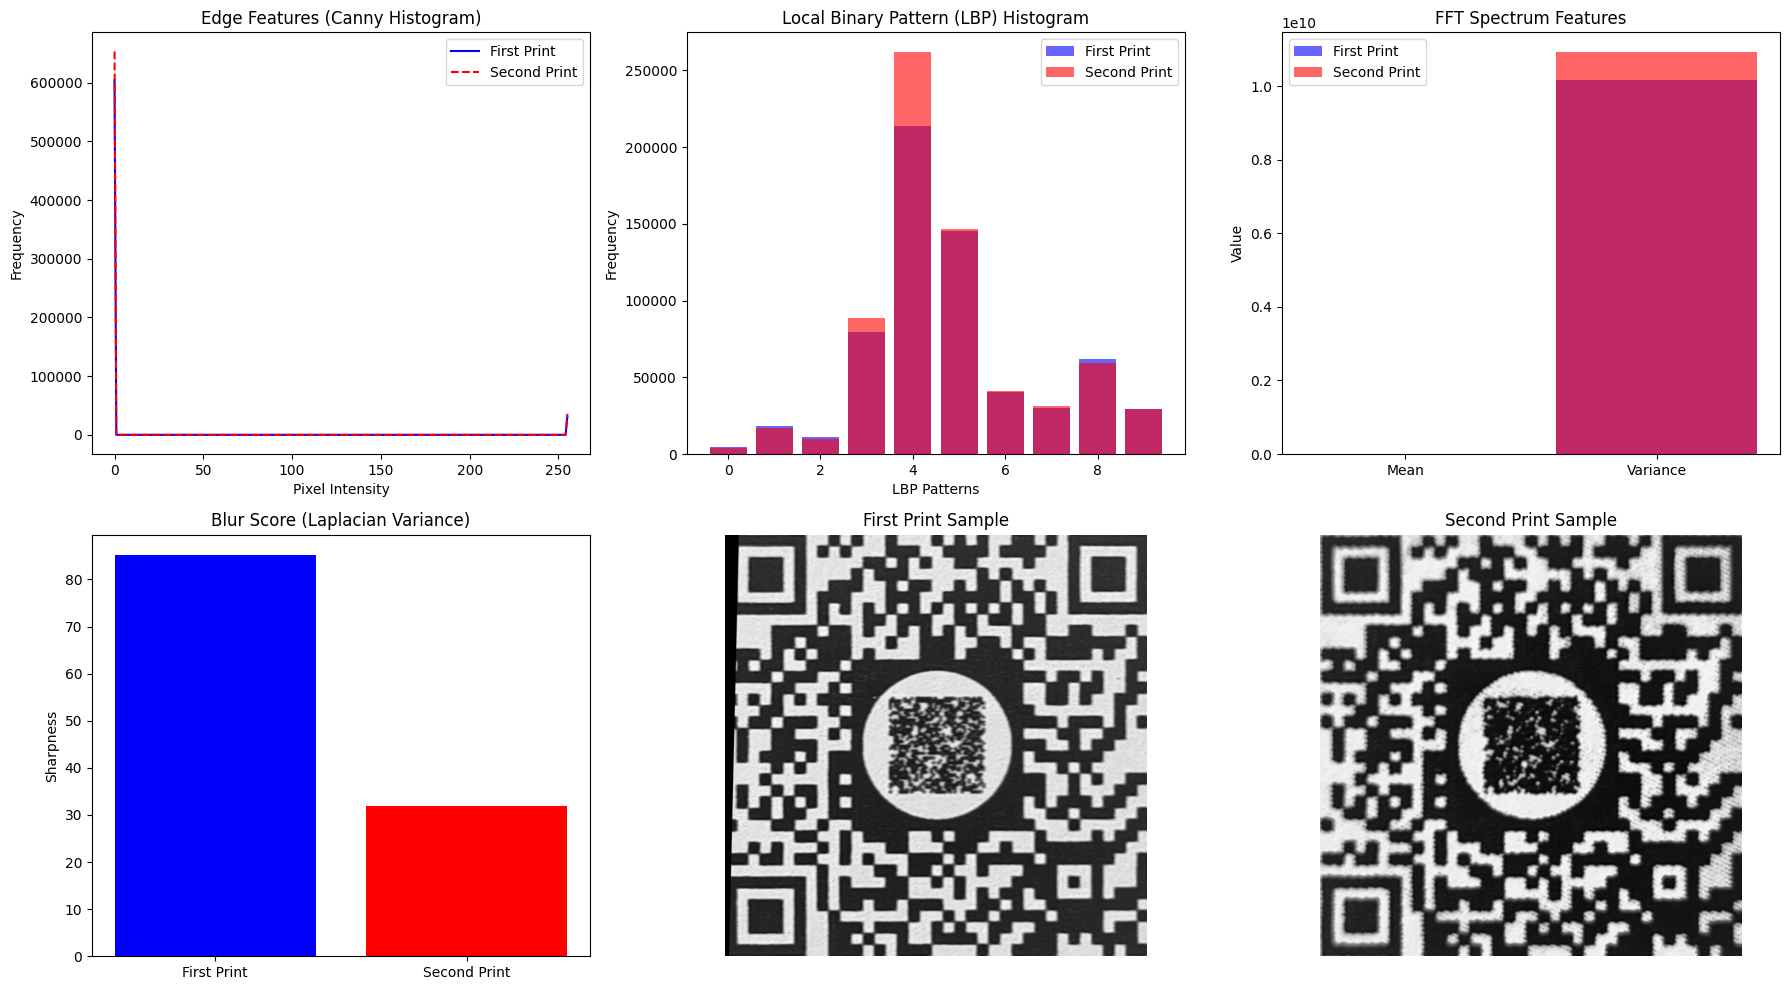

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

first_print_folder = "/content/drive/MyDrive/Assignment Data/First Print"
second_print_folder = "/content/drive/MyDrive/Assignment Data/Second Print"

first_img_path = os.path.join(first_print_folder, os.listdir(first_print_folder)[0])
second_img_path = os.path.join(second_print_folder, os.listdir(second_print_folder)[0])

first_image = cv2.imread(first_img_path, cv2.IMREAD_GRAYSCALE)
second_image = cv2.imread(second_img_path, cv2.IMREAD_GRAYSCALE)

def edge_features(image):
    edges = cv2.Canny(image, 100, 200)
    return np.histogram(edges, bins=256)[0]

def lbp_features(image):
    lbp = local_binary_pattern(image, P=8, R=1, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    return hist

def fft_features(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.abs(fshift)
    return [np.mean(magnitude_spectrum), np.var(magnitude_spectrum)]

def detect_blur(image):
    return [cv2.Laplacian(image, cv2.CV_64F).var()]


first_edge_hist = edge_features(first_image)
second_edge_hist = edge_features(second_image)

first_lbp_hist = lbp_features(first_image)
second_lbp_hist = lbp_features(second_image)

first_fft_mean, first_fft_var = fft_features(first_image)
second_fft_mean, second_fft_var = fft_features(second_image)

first_blur_score = detect_blur(first_image)[0]
second_blur_score = detect_blur(second_image)[0]


fig, ax = plt.subplots(2, 3, figsize=(18, 10))


ax[0, 0].plot(first_edge_hist, color='blue', label='First Print')
ax[0, 0].plot(second_edge_hist, color='red', linestyle='dashed', label='Second Print')
ax[0, 0].set_title("Edge Features (Canny Histogram)")
ax[0, 0].set_xlabel("Pixel Intensity")
ax[0, 0].set_ylabel("Frequency")
ax[0, 0].legend()


ax[0, 1].bar(range(len(first_lbp_hist)), first_lbp_hist, color='blue', alpha=0.6, label="First Print")
ax[0, 1].bar(range(len(second_lbp_hist)), second_lbp_hist, color='red', alpha=0.6, label="Second Print")
ax[0, 1].set_title("Local Binary Pattern (LBP) Histogram")
ax[0, 1].set_xlabel("LBP Patterns")
ax[0, 1].set_ylabel("Frequency")
ax[0, 1].legend()


ax[0, 2].bar(["Mean", "Variance"], [first_fft_mean, first_fft_var], color='blue', alpha=0.6, label="First Print")
ax[0, 2].bar(["Mean", "Variance"], [second_fft_mean, second_fft_var], color='red', alpha=0.6, label="Second Print")
ax[0, 2].set_title("FFT Spectrum Features")
ax[0, 2].set_ylabel("Value")
ax[0, 2].legend()


ax[1, 0].bar(["First Print", "Second Print"], [first_blur_score, second_blur_score], color=['blue', 'red'])
ax[1, 0].set_title("Blur Score (Laplacian Variance)")
ax[1, 0].set_ylabel("Sharpness")


ax[1, 1].imshow(first_image, cmap='gray')
ax[1, 1].set_title("First Print Sample")
ax[1, 1].axis('off')

ax[1, 2].imshow(second_image, cmap='gray')
ax[1, 2].set_title("Second Print Sample")
ax[1, 2].axis('off')

plt.tight_layout()
plt.show()


**Data Preprocessing**

In [5]:

def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
    return images


first_prints = load_images("/content/drive/MyDrive/Assignment Data/First Print")
second_prints = load_images("/content/drive/MyDrive/Assignment Data/Second Print")
labels = [0] * len(first_prints) + [1] * len(second_prints)
images = first_prints + second_prints


In [6]:
X = []
for img in images:
    features = np.hstack([
        edge_features(img),
        lbp_features(img),
        fft_features(img),
        detect_blur(img),
    ])
    X.append(features)

X = np.array(X)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Training Model using Machine Learning (Random Forest Classifier)

Accuracy: 0.98


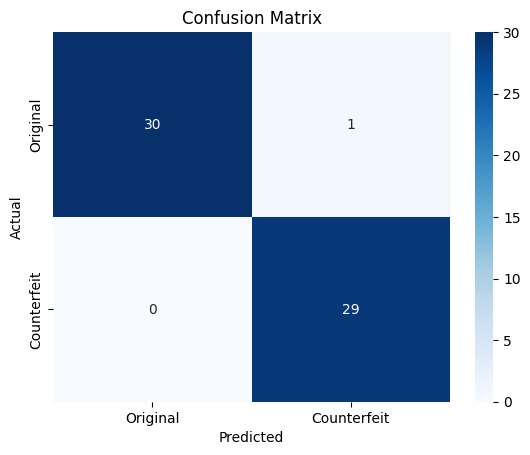

              precision    recall  f1-score   support

    Original       1.00      0.97      0.98        31
 Counterfeit       0.97      1.00      0.98        29

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



In [7]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Original", "Counterfeit"], yticklabels=["Original", "Counterfeit"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, y_pred, target_names=["Original", "Counterfeit"]))


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Training Model Using Deep Learning (CNN model architecture)

1) Preparing Dataset (pytorch framework)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class QRCodeDataset(Dataset):
    def __init__(self, folder, label, transform=None):
        self.folder = folder
        self.label = label
        self.transform = transform
        self.images = os.listdir(folder)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder, self.images[idx])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(self.label, dtype=torch.long)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

first_prints_dataset = QRCodeDataset("/content/drive/MyDrive/Assignment Data/First Print", label=0, transform=transform)
second_prints_dataset = QRCodeDataset("/content/drive/MyDrive/Assignment Data/Second Print", label=1, transform=transform)

dataset = first_prints_dataset + second_prints_dataset
dataset = torch.utils.data.ConcatDataset([first_prints_dataset, second_prints_dataset])

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 140, Validation: 30, Test: 30


CNN Model Architecture

In [11]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = CNNModel().to(device)


Model Training

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(train_accuracy)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_accuracy = 100 * correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%")

print("Training Complete!")


Epoch [1/10] - Train Loss: 2.7042, Train Acc: 52.14% | Val Loss: 0.6600, Val Acc: 56.67%
Epoch [2/10] - Train Loss: 0.6699, Train Acc: 61.43% | Val Loss: 0.6766, Val Acc: 76.67%
Epoch [3/10] - Train Loss: 0.6565, Train Acc: 78.57% | Val Loss: 0.6503, Val Acc: 66.67%
Epoch [4/10] - Train Loss: 0.5659, Train Acc: 76.43% | Val Loss: 0.5277, Val Acc: 73.33%
Epoch [5/10] - Train Loss: 0.4393, Train Acc: 77.14% | Val Loss: 0.5294, Val Acc: 66.67%
Epoch [6/10] - Train Loss: 0.3724, Train Acc: 82.86% | Val Loss: 0.4314, Val Acc: 70.00%
Epoch [7/10] - Train Loss: 0.2772, Train Acc: 88.57% | Val Loss: 0.2777, Val Acc: 100.00%
Epoch [8/10] - Train Loss: 0.2244, Train Acc: 93.57% | Val Loss: 0.2946, Val Acc: 83.33%
Epoch [9/10] - Train Loss: 0.1456, Train Acc: 96.43% | Val Loss: 0.1520, Val Acc: 100.00%
Epoch [10/10] - Train Loss: 0.1233, Train Acc: 96.43% | Val Loss: 0.1389, Val Acc: 93.33%
Training Complete!


**Model Prediction**

              precision    recall  f1-score   support

   Authentic       1.00      1.00      1.00        11
 Counterfeit       1.00      1.00      1.00        19

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



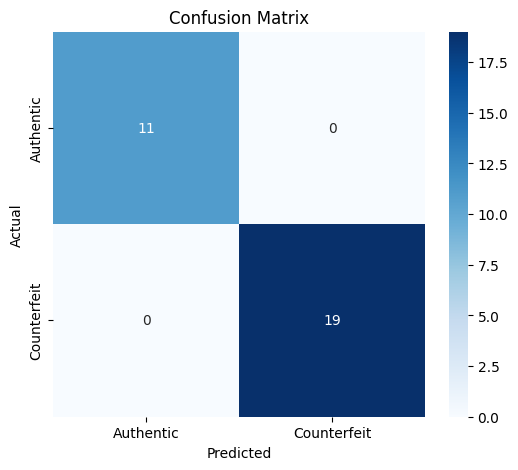

In [13]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
print(classification_report(y_true, y_pred, target_names=["Authentic", "Counterfeit"]))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Authentic", "Counterfeit"], yticklabels=["Authentic", "Counterfeit"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
